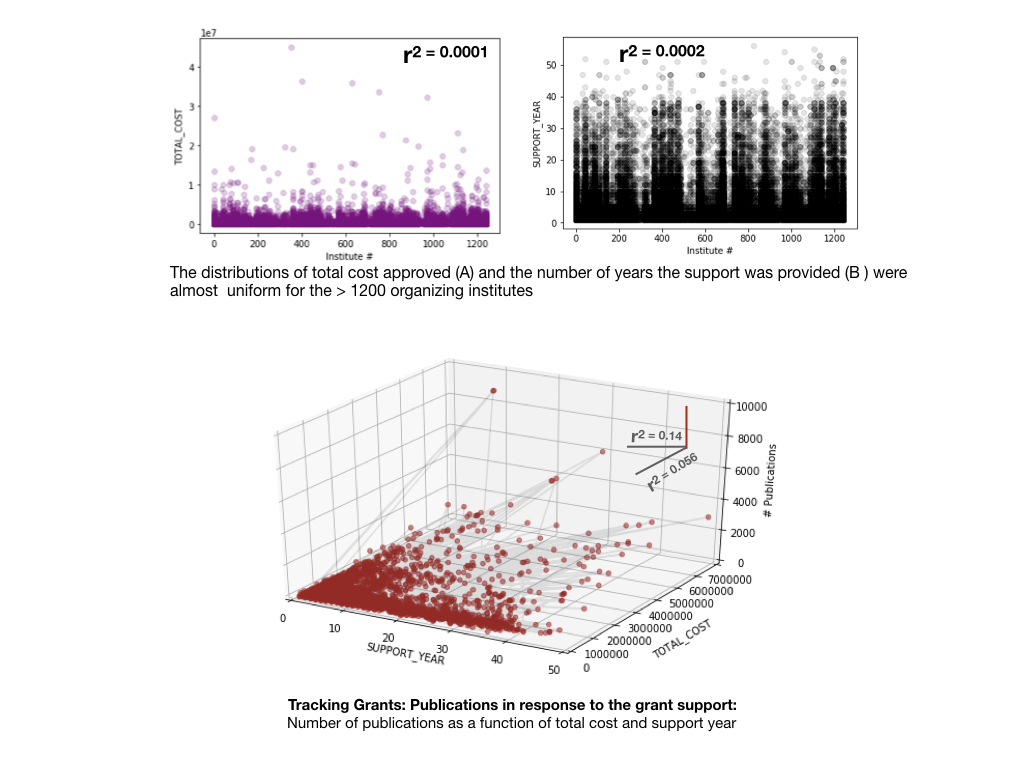

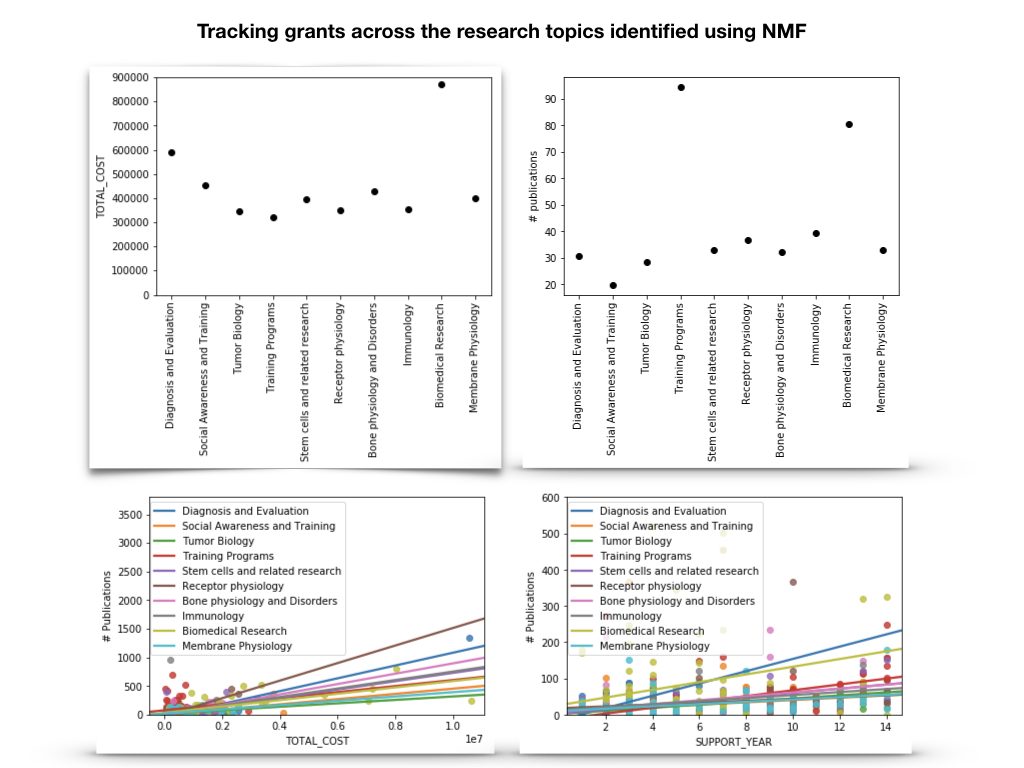

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfnew = pd.read_csv('RePORTER_PRJ_C_FY2012.csv',encoding='latin')
dfnew['numpub']=pd.read_excel('numpub.xlsx')
df = dfnew.dropna(axis=0,subset=['DIRECT_COST_AMT', 'INDIRECT_COST_AMT', 'TOTAL_COST'])
df.reset_index(drop=True, inplace=True)

tags = df.PROJECT_TERMS.tolist()
tags = str(tags)
chara = ['[',']']
for i in chara:
    tags = tags.replace(i, "")
tags = [x.strip() for x in tags.split(';')]
tags = list(set(tags))
train = df.PROJECT_TERMS.tolist()
train = list(map(str,train))

#%%    
#  Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=tags)
matrix = vectorizer.fit_transform(train)   #text=text1+text2


#save matrix
def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)
    
save_sparse_csr('prjphrases_tfidf', matrix)  #saved as .npz


#load matrix
def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])
    
from scipy.sparse import csr_matrix  
articles = load_sparse_csr('prjphrases_tfidf.npz')

titles = df.PROJECT_TITLE.tolist()


from sklearn.decomposition import NMF

model = NMF(n_components = 10)

model.fit(articles)

nmf_features1 = model.transform(articles)

df1 = pd.DataFrame(nmf_features1,index=titles) #PROJECT_TITLEs


from sklearn.preprocessing import normalize
norm_features = normalize(nmf_features1)

for i in range(0,10):
    new = df1[i].sort_values(ascending=False)
    print(new[:10]) #(top 10 projects under each topic
#%%
#similar projects    
article = df1.iloc[6]
similarities = df1.dot(article)
print(article)
print('similarities:\n',similarities.nlargest())
sim = similarities.sort_values(ascending=False)


In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

grdf = pd.read_csv('RePORTER_PRJ_C_FY2012.csv',encoding='latin')

#import subprocess
#output = subprocess.check_output('esearch -db pubmed -query "TS000118[gr]"|grep Count', shell=True)

numpub = np.zeros(10000, np.int32)
i=-1
for s in grdf.CORE_PROJECT_NUM[0]:
    i+=1
    query = str(s[-8:])+'[gr]'
    # pubmed API
    url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term='+query+'&rettype=count'
    r = requests.get(url)
    html_doc = r.text
    a = int(re.search('Count>\d{1,}',html_doc).group(0)[6:]) #get count (# publications)
    print(i,a)
    numpub[i] = a  #tracked for 20000 requests (25% data)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfnew = pd.read_csv('RePORTER_PRJ_C_FY2012.csv',encoding='latin') #NIH 2012 project report
dfnew['numpub']=pd.read_excel('numpub.xlsx') #pubmed publications tracked using CORE_PROJECT_NUM
df = dfnew.dropna(axis=0,subset=['DIRECT_COST_AMT', 'INDIRECT_COST_AMT', 'TOTAL_COST'])
df.reset_index(drop=True, inplace=True)

inst = list(set(df.ORG_NAME))
instind = []
for i in range(len(df.ORG_NAME)):
   instind.append(inst.index(df.ORG_NAME[i]))
plt.scatter(instind,df.TOTAL_COST)

np.corrcoef(instind,df.SUPPORT_YEAR,1) #0.01415972
np.corrcoef(instind,df.TOTAL_COST,1)    #0.01151104

pub = list(df.numpub)
for s in pub:
    if type(s) == str:
        strind = (pub.index(s))     #str in pubmed results
        df.numpub[strind] = 0


#%%

import seaborn as sns

df1 = pd.DataFrame(nmf_features1,index=df.index)
df1['numpub'] = df.numpub
df1['TOTAL_COST'] = df.TOTAL_COST
df1['SUPPORT_YEAR'] = df.SUPPORT_YEAR
df2 = df1[:8925]

sns.regplot(df2.SUPPORT_YEAR,df2.numpub)   
plt.show()
np.corrcoef([list(df2.SUPPORT_YEAR),list(df2.numpub)])
#0.37154902
sns.regplot(df2.TOTAL_COST,df2.numpub)
np.corrcoef([list(df2.TOTAL_COST),list(df2.numpub)])
#0.23682579
plt.show()
#%%

import seaborn as sns
topics = ['Diagnosis and Evaluation','Social Awareness and Training','Tumor Biology','Training Programs','Stem cells and related research','Receptor physiology','Bone physiology and Disorders','Immunology','Biomedical Research','Membrane Physiology']


#Avearge Publications for top 100 represenatives in each category
for i in range(10):
   df2 = df2.sort_values([i],ascending=False)
   print(np.mean(df2.numpub[:100]))
'''   
30.75
19.78
28.4
94.35
32.82
36.52
32.17
39.42
80.52
32.97
'''

#Avearge cost for top 100 represenatives in each category
a=[]
for i in range(10):
   df2 = df2.sort_values([i],ascending=False)
   print(np.mean(df2.TOTAL_COST[:100]))
   a.append(np.mean(df2.TOTAL_COST[:100]))
plt.scatter(np.arange(10),a,c='black');plt.ylim(0,900000);plt.ylabel('TOTAL_COST');plt.xticks(np.arange(10), topics, rotation='vertical')
'''   
590390.55
453477.95
347373.12
320838.66
395015.63
349073.74
427276.44
355409.6
872403.37
400037.18
'''
# TOTAL_COST Vs. Publications for top 100 represenative projects in each category
for i in range(10):
   df2 = df2.sort_values([i],ascending=False)
   print(np.corrcoef([list(df2.TOTAL_COST[:100]),list(df2.numpub[:100])])[0][1])
'''
0.921805184786
0.665258772994
0.218006316749
0.193314105614
0.451915884929
0.83224807934
0.789819953331
0.180046086161
0.742728339939
0.408166340466
'''

for i in range(10):
   df2 = df2.sort_values([i],ascending=False)
   sns.regplot(df2.TOTAL_COST[:100],df2.numpub[:100],ci=None);plt.ylim(0,3800);plt.ylabel('# Publications');plt.legend(labels=topics,loc='upper right', bbox_to_anchor=(0.6, 1))
plt.show()

# SUPPORT_YEAR Vs. Publications for top 100 represenative projects in each category
for i in range(10):
   df2 = df2.sort_values([i],ascending=False)
   print(np.corrcoef([list(df2.SUPPORT_YEAR[:100]),list(df2.numpub[:100])])[0][1])
'''
0.250021446659
0.237542494755
0.760850542462
0.706943801126
0.604915750073
0.285664029429
0.575080259546
0.275548559345
0.284251274102
0.676719879174
'''

for i in range(10):
   df2 = df2.sort_values([i],ascending=False)
   sns.regplot(df2.SUPPORT_YEAR[:100],df2.numpub[:100],ci=None);plt.ylim(0,3800);plt.ylabel('# Publications');plt.legend(labels=topics,loc='upper right', bbox_to_anchor=(0.6, 1))
plt.show()
#%% 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.DataFrame(nmf_features1,index=df.index)
df.numpub[0] = 0
df1['numpub'] = df.numpub
df1['TOTAL_COST'] = df.TOTAL_COST
df1['SUPPORT_YEAR'] = df.SUPPORT_YEAR
df2 = df1[:8925]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m in [('r', 'o'), ('b', '^')]:
    xs = df2.SUPPORT_YEAR
    ys = df2.TOTAL_COST
    ys[ys > 0.9e7] = np.nan
    zs = df2.numpub
    ax.scatter(xs, ys, zs, c='firebrick',alpha=0.3)
    ax.plot(xs, ys, zs, c='black',alpha=0.05)
#ax.scatter(df2.SUPPORT_YEAR[:100], df2.TOTAL_COST[:100], df2.numpub[:100],c=['r','b'])

ax.set_xlabel('SUPPORT_YEAR')
ax.set_ylabel('\n\n'+'TOTAL_COST')
ax.set_zlabel('# Publications')

ax.set_xlim(0,50)
ax.set_ylim(0,7e6)
ax.set_zlim(0,10000)
              
              
plt.show()